
# **Loading all the needed libraries**

In [ ]:
%%capture
!pip install transformers

In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

# **Download SQuAD 2.0 dataset and Tranformers library**

In [ ]:
#get SQuAD v2
%%capture
!mkdir squad
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

# **Retrieve and Store the data**

In [ ]:
# Give the path for train data
path = Path('squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
# Give the path for validation data
path = Path('squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

# **Check the data**

In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

86821
86821
86821
Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

20302
20302
20302
Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


# **Find the end position character**

In [ ]:
# Find end position character in train data

for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
# Find end position character in validation data

for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

# **Tokenize passages and queries**

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

# **Convert the start-end positions to tokens start-end positions**

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
16


# **Create a Dataset class**

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

# **Use of DataLoader**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# **Use GPU**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

# **Build the Bert model**

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
# epochs = 3
epochs = 4

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# **Train and Evaluate Model**

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 10853 
Loss: 0.6 

Batch 2000 / 10853 
Loss: 1.2 

Batch 3000 / 10853 
Loss: 1.0 

Batch 4000 / 10853 
Loss: 1.3 

Batch 5000 / 10853 
Loss: 0.3 

Batch 6000 / 10853 
Loss: 0.7 

Batch 7000 / 10853 
Loss: 2.1 

Batch 8000 / 10853 
Loss: 0.8 

Batch 9000 / 10853 
Loss: 1.9 

Batch 10000 / 10853 
Loss: 1.6 

############Evaluate############
Batch 1000 / 2538 
Loss: 0.2 

Batch 2000 / 2538 
Loss: 0.1 


-------Epoch  1 -------
Training Loss: 1.3419355338637229 
Validation Loss: 1.179255813104816 
Time:  8858.358568906784 
----------------------- 


############Train############
Batch 1000 / 10853 
Loss: 0.9 

Batch 2000 / 10853 
Loss: 0.8 

Batch 3000 / 10853 
Loss: 1.3 

Batch 4000 / 10853 
Loss: 1.0 

Batch 5000 / 10853 
Loss: 1.5 

Batch 6000 / 10853 
Loss: 1.8 

Batch 7000 / 10853 
Loss: 0.9 

Batch 8000 / 10853 
Loss: 1.7 

Batch 9000 / 10853 
Loss: 1.2 

Batch 10000 / 10853 
Loss: 0.5 

############Evaluate############
Batch 1000 / 2538 
Lo

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save model
torch.save(model.state_dict(), "/content/drive/MyDrive/finetunedmodel/finetuned_model_2.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save model
torch.save(model, "/content/drive/MyDrive/finetunedmodel/finetuned_model_3.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save model
torch.save(model, "/content/drive/MyDrive/finetunedmodel/finetuned_model_4.pt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


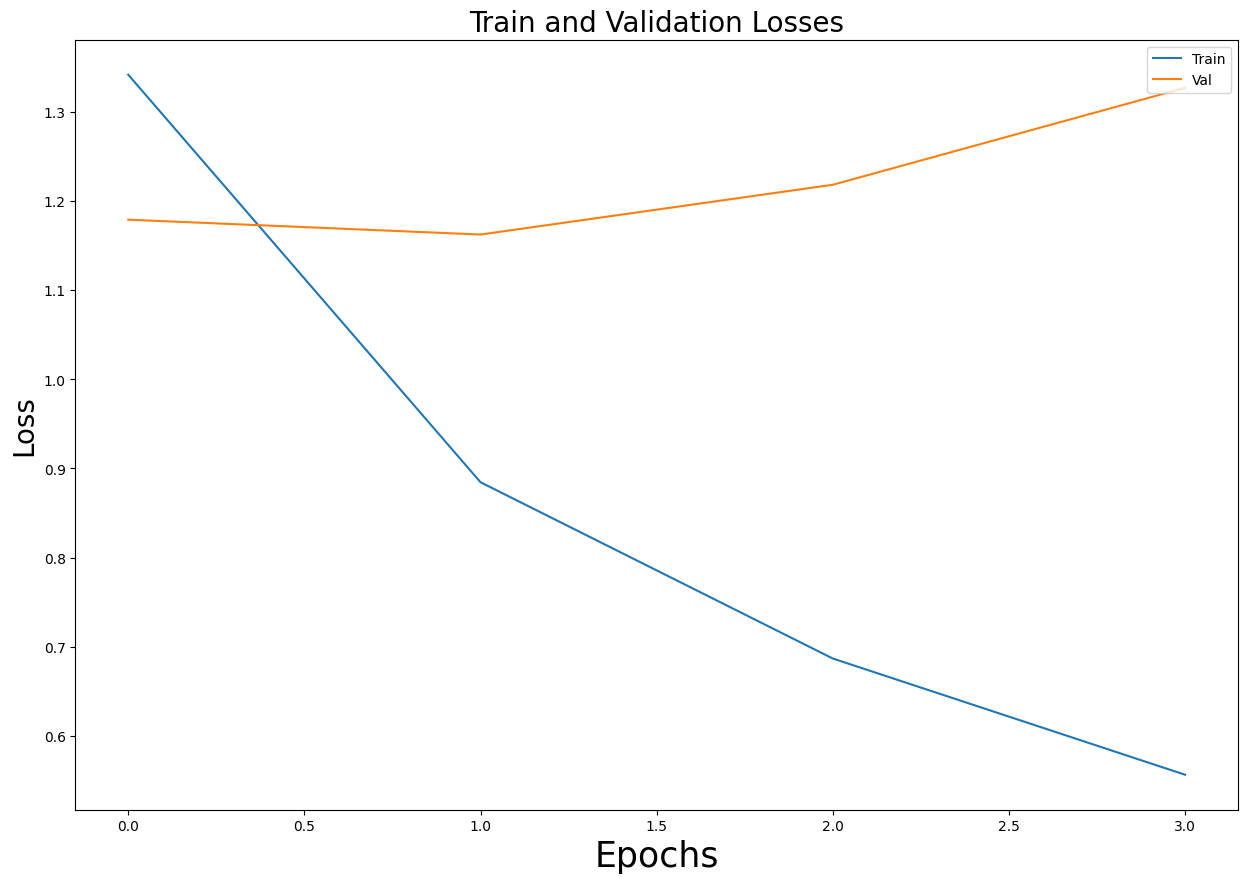

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')